<a href="https://colab.research.google.com/github/saquibali7/VideoFramePrediction/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.7.2, 2.7.2+zzzcolab20220516114640, 2.7.3, 2.7.3+zzzcolab20220523111007, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.0+zzzcolab20220506162203, 2.8.1, 2.8.1+zzzcola

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Concatenate, LeakyReLU, Input, Activation, ReLU
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
weight_initialzer = RandomNormal(stddev=0.02)

In [34]:
img_width = 256
img_height = 256
num_channels = 3
num_stacked_imgs = 4

In [33]:
def residual_block(filters,previous, input):
    for i in range(9):
        x = Conv2D(filters,3,strides=1, padding='same', kernel_initializer=weight_initialzer)(input)
        x = InstanceNormalization(axis=-1)(x)
        x = ReLU()(x)
        x = Conv2D(filters,3,strides=1, padding='same', kernel_initializer=weight_initialzer)(x)
        x = InstanceNormalization(axis=-1)(x)

        if previous is not None:
            x_out = Concatenate()([previous, x])
            previous = x_out
            input = x_out
        else:
            previous = x
            input = x

    return x_out

In [6]:
def generator():
    x1 = Input(shape = (img_width,img_height,num_channels*num_stacked_imgs))
    x2 = Conv2D(128,kernel_size=7,strides=1,padding='same',kernel_initializer=weight_initialzer)(x1)
    x3 = Conv2D(128,kernel_size=3,strides=2,padding='same',kernel_initializer=weight_initialzer)(x2)
    x3 = InstanceNormalization(axis=-1)(x3)
    x3 = ReLU()(x3)
    x4 = Conv2D(256,kernel_size=3,strides=2,padding='same',kernel_initializer=weight_initialzer)(x3)
    x4 = InstanceNormalization(axis=-1)(x4)
    x4 = ReLU()(x4)
    x13 = residual_block(256,None,x4)
    x14 = Conv2DTranspose(128,kernel_size=3,strides=2, padding='same', kernel_initializer=weight_initialzer)(x13)
    x14 = InstanceNormalization(axis=-1)(x14)
    x14 = ReLU()(x14)
    x15 = Conv2DTranspose(256,kernel_size=3,strides=2,padding='same',kernel_initializer=weight_initialzer)(x14)
    x15 = InstanceNormalization(axis=-1)(x15)
    x15 = ReLU()(x15)
    x16 = Conv2D(3,kernel_size=7,strides=1, padding='same',kernel_initializer=weight_initialzer,activation='tanh')(x15)
    return Model(x1,x16)


In [7]:
def discriminator_block(filters,strides, input):
    x = Conv2D(filters,kernel_size=4, strides=strides,padding='same',kernel_initializer=weight_initialzer)(input)
    x= InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(0.2)(x)

    return x

def discriminator(num_input_images):
    x1 = Input(shape=(img_width,img_height,num_channels*num_input_images))
    x2 = Conv2D(64,kernel_size=4,strides=2,padding='same',kernel_initializer=weight_initialzer)(x1)
    x2 = LeakyReLU(0.2)(x2)
    x3 = discriminator_block(128,2,x2)
    x4 = discriminator_block(256,2,x3)
    x5 = discriminator_block(512,1,x4)
    x6 = Conv2D(1,kernel_size=4,strides=1,padding='same',kernel_initializer=weight_initialzer)(x5)
    return Model(x1,x6)



In [8]:
future_generator = generator()
future_generator.summary()

frame_discriminator = discriminator(1)
frame_discriminator.summary()

sequence_discriminator = discriminator(5)
sequence_discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  75392       ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  147584      ['conv2d[0][0]']                 
                                8)                                                            

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [12]:
data_path = '/content/drive/MyDrive/t2_Videos_GAN'
data = os.listdir(data_path)

In [13]:
import random
image = list()
for i in range(30):
  idx = random.randint(0,len(data))
  cap= cv2.VideoCapture(os.path.join(data_path,data[i]))
  temp = []
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256,256))
      image.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  
  cap.release()
  cv2.destroyAllWindows()    


In [14]:
image = np.array(image)
print(image.shape)

(1064, 256, 256, 3)


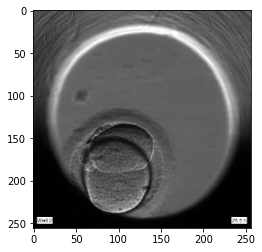

In [15]:
ix = np.random.randint(0,image.shape[0])
plt.imshow(image[ix])

In [16]:
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import cv2
import time
import math

lambda1 = 0.005
lambda2 = 0.003
lambda3 = 0.003

epochs = 100

beta1 = 0.5
beta2 = 0.999

future_generator_optimizer = Adam(lr=0.0003,beta_1=beta1,beta_2= beta2)
frame_discriminator_optimizer = sequence_discriminator_optimizer = Adam(lr=0.0003,beta_1=beta1,beta_2= beta2)
loss = BinaryCrossentropy(from_logits=True)

checkpoint_dirs = '/content/drive/MyDrive/framePrediction'
checkpoint_prefix = os.path.join(checkpoint_dirs,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = future_generator_optimizer, frame_discriminator_optimizer = frame_discriminator_optimizer, sequence_discriminator_optimizer = sequence_discriminator_optimizer, generator = future_generator, frame_discriminator = frame_discriminator, sequence_discriminator = sequence_discriminator)

def LoG(image, filtersize=7, sigma=1):

    image = (image+1)*127.5
    image = tf.squeeze(image,axis=0)
    image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    image = tf.squeeze(image,2) 
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    n_channels = 1
    image = tf.expand_dims(image, 2)
    
    w = math.ceil(sigma * filtersize)
    w_range = int(math.floor(w/2))

    y = x = tf.range(-w_range, w_range+1, 1)
    Y, X = tf.meshgrid(x, y)
    z = tf.cast(tf.add(tf.square(X), tf.square(Y)),tf.float32)
    nom = tf.subtract(z, 2*(sigma**2))
    denom = 2*math.pi*(sigma**6)
    exp = tf.exp( -z/2*(sigma**2))
    fil = tf.divide(tf.multiply(nom, exp), denom)
    
    fil = tf.stack([fil]*n_channels, axis=2)
    fil = tf.expand_dims(fil, 3)
    
    new = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    new = tf.expand_dims(new, 0)
    res = tf.nn.depthwise_conv2d(new, fil, strides=[1, 1, 1, 1], padding="SAME")
    res = tf.squeeze(res,0)
    res = tf.squeeze(res,2)
    minM = tf.math.reduce_min(res)
    maxM = tf.math.reduce_max(res)
    output = (res - minM) * 255 / (maxM - minM)
    output = tf.expand_dims(output,axis=0)
    output = output/127.5-1
    return output

def discriminator_loss(fake,real):

    return (loss(tf.ones_like(real),real) + loss(tf.zeros_like(fake),fake))*0.5

def image_similarity(img1,img2):

    return tf.reduce_mean(tf.abs(img1 - img2))

def LoG_image_similarity(img1,img2):

    return tf.reduce_mean(tf.abs(LoG(img1) - LoG(img2)))


@tf.function
def step(xm_to_xnplus1):
    xm_to_xn = xm_to_xnplus1[:,:,0:12]
    xm_to_xn = xm_to_xn/255
    xm_to_xn = tf.expand_dims(xm_to_xn,axis = 0)
    xn_plus_1 = xm_to_xnplus1[:,:,12:15]

    xn_plus_1 = xn_plus_1/127.5 - 1
    xn_plus_1 = tf.expand_dims(xn_plus_1,axis=0)

    xm_plus_1_to_xn_plus_1 = xm_to_xnplus1[:,:,3:]
    xm_plus_1_to_xn_plus_1 = xm_plus_1_to_xn_plus_1/255
    xm_plus_1_to_xn_plus_1 = tf.expand_dims(xm_plus_1_to_xn_plus_1,axis=0)
    
    xm = xm_to_xnplus1[:,:,0:3]
    xm = xm/127.5 -1
    xm = tf.expand_dims(xm,axis=0)

    with tf.GradientTape(persistent=True) as tape:

        xn_plus_1_dash = future_generator(xm_to_xn,training = True)
        xm_dash = future_generator(xm_plus_1_to_xn_plus_1[::-1],training = True)

        xm_to_xn_false = tf.concat((xm_dash,xm_to_xn[:,:,:,3:12]),axis = -1) 

        xm_plus_1_to_xn_plus_1_false = tf.concat((xm_plus_1_to_xn_plus_1[:,:,:,0:9],xn_plus_1_dash),axis=-1)

        xn_plus_1_double_dash = future_generator(xm_to_xn_false, training = True)
        xm_double_dash = future_generator(xm_plus_1_to_xn_plus_1_false[::-1])

        frame_discriminator_loss = lambda2*(discriminator_loss(frame_discriminator(xn_plus_1_dash,training=True),frame_discriminator(xn_plus_1,training=True)) + discriminator_loss(frame_discriminator(xn_plus_1_double_dash,training =True),frame_discriminator(xn_plus_1,training=True)) + discriminator_loss(frame_discriminator(xm_dash,training=True),frame_discriminator(xm,training=True)) + discriminator_loss(frame_discriminator(xm_double_dash,training=True),frame_discriminator(xm,training=True)))

        with tape.stop_recording():

            frame_discriminator_gradients = tape.gradient(frame_discriminator_loss, frame_discriminator.trainable_variables)
            frame_discriminator_optimizer.apply_gradients(zip(frame_discriminator_gradients,frame_discriminator.trainable_variables))

        xm_to_xnplus1 = tf.expand_dims(xm_to_xnplus1,axis = 0)/127.5-1

        xm_to_xn_with_xn_plus_1_dash = tf.concat((xm_to_xnplus1[:,:,:,0:12],xn_plus_1_dash),axis = -1)

        xm_to_xn_with_xn_plus_1_double_dash = tf.concat((xm_to_xnplus1[:,:,:,0:12],xn_plus_1_double_dash),axis=-1)

        xm_to_xn_with_xm_dash = tf.concat((xm_dash,xm_to_xnplus1[:,:,:,3:]),axis =-1)

        xm_to_xn_with_xm_double_dash = tf.concat((xm_double_dash,xm_to_xnplus1[:,:,:,3:]),axis=-1)

        sequence_discriminator_loss = lambda3*(discriminator_loss(sequence_discriminator(xm_to_xn_with_xm_dash,training=True), sequence_discriminator(xm_to_xnplus1,training=True)) + discriminator_loss(sequence_discriminator(xm_to_xn_with_xn_plus_1_double_dash,training=True),sequence_discriminator(xm_to_xnplus1,training=True)) + discriminator_loss(sequence_discriminator(xm_to_xn_with_xm_dash[::-1],training=True),sequence_discriminator(xm_to_xnplus1[::-1],training=True)) + discriminator_loss(sequence_discriminator(xm_to_xn_with_xm_double_dash[::-1],training=True), sequence_discriminator(xm_to_xnplus1[::-1],training=True)))

        with tape.stop_recording():

            sequence_discriminator_gradients = tape.gradient(sequence_discriminator_loss, sequence_discriminator.trainable_variables)
            sequence_discriminator_optimizer.apply_gradients(zip(sequence_discriminator_gradients,sequence_discriminator.trainable_variables))

        img_loss = image_similarity(xm,xm_dash) + image_similarity(xm,xm_double_dash) + image_similarity(xm_dash,xm_double_dash) + image_similarity(xn_plus_1,xn_plus_1_dash) + image_similarity(xn_plus_1,xn_plus_1_double_dash) + image_similarity(xn_plus_1_dash,xn_plus_1_double_dash)
        LoG_loss = LoG_image_similarity(xm,xm_dash) + LoG_image_similarity(xm,xm_double_dash) + LoG_image_similarity(xm_dash,xm_double_dash) + LoG_image_similarity(xn_plus_1,xn_plus_1_dash) + LoG_image_similarity(xn_plus_1,xn_plus_1_double_dash) + LoG_image_similarity(xn_plus_1_dash,xn_plus_1_double_dash)

        future_generator_loss = img_loss + lambda1*LoG_loss

        with tape.stop_recording():

            future_generator_gradients = tape.gradient(future_generator_loss,future_generator.trainable_variables)
            future_generator_optimizer.apply_gradients(zip(future_generator_gradients,future_generator.trainable_variables))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
import random
import matplotlib.pyplot as plt
from math import log10, sqrt
from tqdm import tqdm

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dirs))

def PSNR(expected,Predicted): 
    mse = np.mean((expected - Predicted) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return mse,psnr 

In [ ]:
def generate_images(input_array):

  first = random.randint(1,image.shape[0]-5)
  input1 = image[first]
  input2 = image[first+1]
  input3 = image[first+2]
  input4 = image[first+3]
  expected = image[first+4]

  expected = expected/255
  input_to = np.concatenate([input1,input2,input3,input4],axis= -1)
  input_to = tf.expand_dims(input_to,axis=0)

  out1 = future_generator(input_to)
  out = tf.squeeze(out1,axis = 0)
  out = (out + 1.0)/2
  out.numpy()

  plt.figure(figsize=(15,15))
  title = ['Ground Truth','Predicted']
  display_list = [expected,out]
  for i in range(2):

        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

  plt.show()
  mse,psnr = PSNR(expected*255,out*255)
  print("MSE value is {}".format(mse))
  print("PNSR value is {}".format(psnr))
  # ssim = tf.image.ssim(expected, out, max_val=1, filter_size=11,
  #                         filter_sigma=1.5, k1=0.01, k2=0.03)
  # print("SSIM value is {}".format(ssim))

for epoch in range(epochs):
    print('Epochs:{}'.format(epoch))
    start = time.time()
    for i in range(image.shape[0]-5):
      xm = image[i]
      xm_plus1 = image[i+1]
      xm_plus2 = image[i+2]
      xn = image[i+3]
      xn_plus1 = image[i+4]
      xm_to_xnplus1 = np.concatenate([xm,xm_plus1,xm_plus2,xn,xn_plus1], axis = -1)
      xm_to_xnplus1 = xm_to_xnplus1.astype(np.float32)
      step(xm_to_xnplus1)
      if (i+1)%100 == 0:
        print(i)

    generate_images(xm_to_xnplus1)
    print('Time Taken: {}'.format(time.time()-start))

    checkpoint.save(file_prefix=checkpoint_prefix)

Epochs:0


KeyboardInterrupt: ignored

In [18]:
model = tf.keras.models.load_model('/content/drive/MyDrive/framePrediction/model_cycleGAN_03')

In [19]:
def generate_images():

  first = random.randint(1,image.shape[0]-5)
  input1 = image[first]
  input2 = image[first+1]
  input3 = image[first+2]
  input4 = image[first+3]
  expected = image[first+4]

  expected = expected/255
  input_to = np.concatenate([input1,input2,input3,input4],axis= -1)
  input_to = tf.expand_dims(input_to,axis=0)

  out1 = model(input_to)
  out = tf.squeeze(out1,axis = 0)
  out = (out + 1.0)/2
  out.numpy()

  plt.figure(figsize=(15,15))
  title = ['Ground Truth','Predicted']
  display_list = [expected,out]
  for i in range(2):

        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

  plt.show()
  mse,psnr = PSNR(expected*255,out*255)
  print("MSE value is {}".format(mse))
  print("PNSR value is {}".format(psnr))

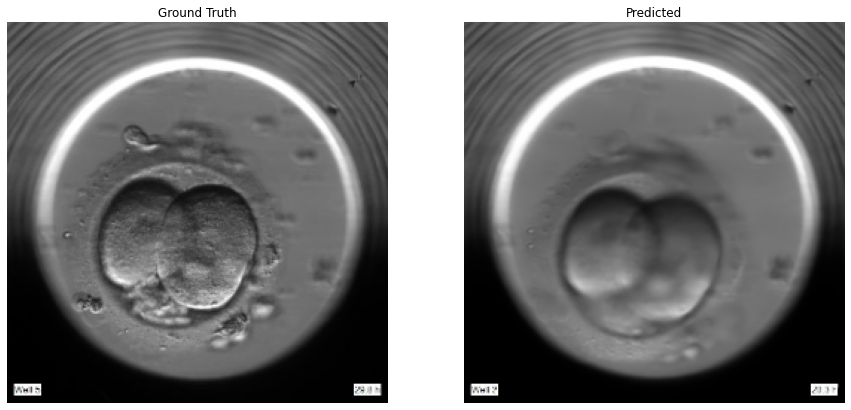

MSE value is 351.229736328125
PNSR value is 22.674890831995754


In [32]:
generate_images()

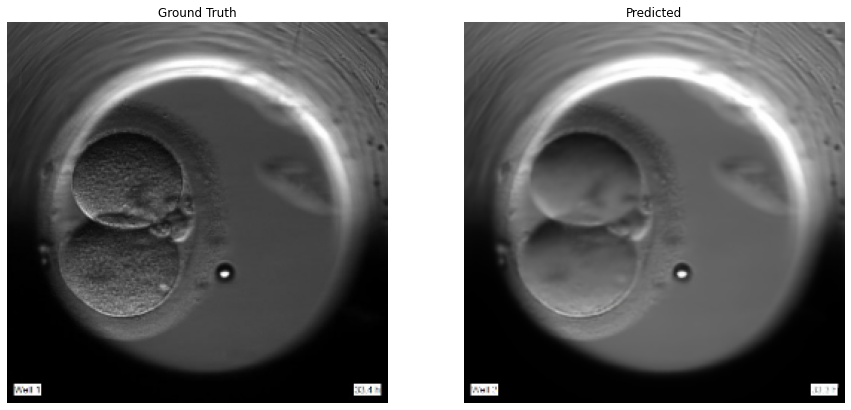

MSE value is 657.4766845703125
PNSR value is 19.952000043783492


In [21]:
generate_images()

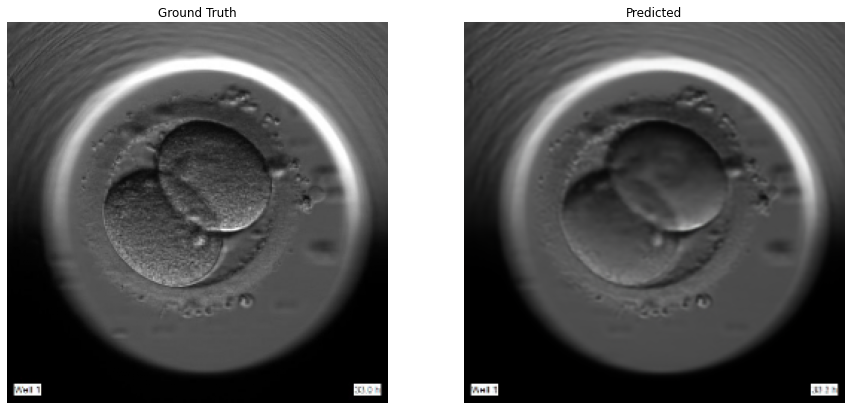

MSE value is 86.02806854248047
PNSR value is 28.784401884119177


In [ ]:
generate_images()